For determining if we see less degeneracy in the solutions as we move to a more complex structure, and for figuring out what complexity really means.

In [213]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from phase_mixing_utils import *
import phase_retrieval as pr
import skimage as ski
import skimage.filters
_SAVEDIR_ = "Images/complexity_degeneracy/"

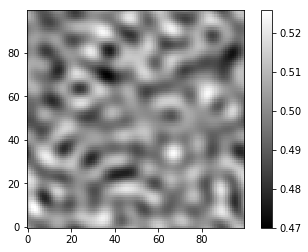

In [22]:


# this a nice random intializing trick I picked up from Bryan Weinstein
nx = 100
ny = 100
random_scale_lat = .001

random_draws = np.random.normal(.5, 0.05, size=(nx, ny))
random_fft = np.fft.fft2(random_draws)
freq_rows = np.fft.fftfreq(random_fft.shape[0])
freq_cols = np.fft.fftfreq(random_fft.shape[1])

X_freq, Y_freq = np.meshgrid(freq_rows, freq_cols)
mag = np.sqrt(X_freq**2 + Y_freq**2)
to_remove = mag > 1./(random_scale_lat+10)

random_fft[to_remove] = 0
ic = np.fft.ifft2(random_fft)

rho1 = np.abs(ic)
plt.imshow(rho1.T,origin = 'lower', cmap=plt.cm.binary_r)
plt.colorbar()
plt.show()

In [33]:
# mags = np.abs(np.fft.fftshift(np.fft.fft2(rho1))).flatten()
FT = np.fft.fft2(rho1)
mags = np.abs(np.fft.fft2(rho1))
# print(np.argmax(mags))
idx = np.unravel_index(mags.argmax(), mags.shape)
print(idx)
mags[idx]=0
# plt.imshow(mags)
# plt.plot(np.abs(np.fft.fftshift(np.fft.fft2(rho1))).flatten())

(0, 0)


In [34]:
FT[0,0] = 0 + 1j*np.imag(FT[0,0])

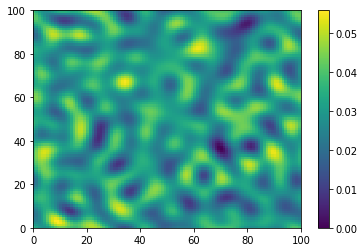

In [49]:
image = np.real_if_close(np.fft.ifft2(FT))
image -= np.min(image)

plt.pcolor(image)
plt.colorbar()
plt.gca()

plt.show()

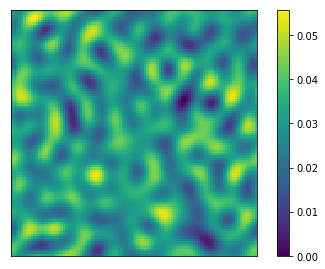

In [218]:
plt.figure()
plt.imshow(image)
plt.tight_layout()
frame1=plt.gca()
frame1.get_xaxis().set_visible(False)
frame1.get_yaxis().set_visible(False)
plt.colorbar()
plt.savefig(_SAVEDIR_+"noise.png")
plt.show()

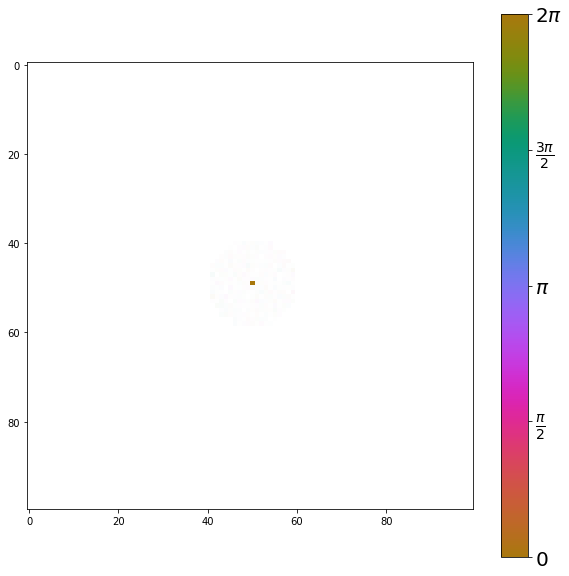

In [50]:
FT = np.fft.fft2(image)
phase_intensity_plot(np.fft.fftshift(FT))

ok, now to try input/output on that

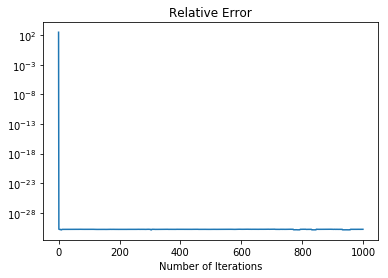

In [51]:
FT = np.fft.fft2(image)
mags = np.abs(FT)
rstrack, err_track = pr.inputoutput(mags)
plt.semilogy(err_track)
plt.title(r"Relative Error")
plt.xlabel(r"Number of Iterations")
plt.show()

In [58]:
final_images = []
for i in range(5):
    rstrack,err_track = pr.inputoutput(mags)
    final_images.append(rstrack[-1])

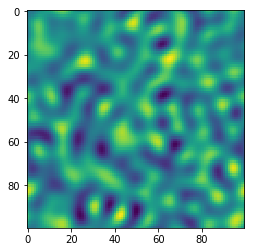

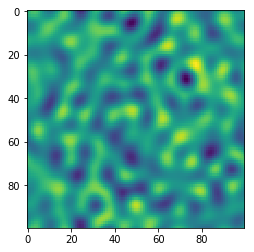

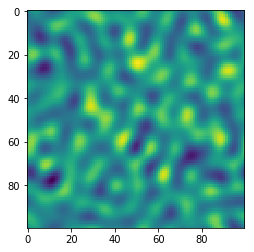

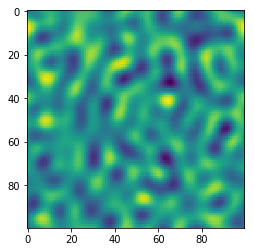

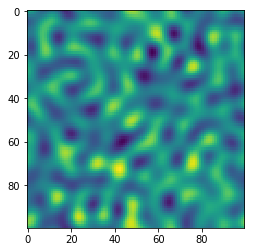

In [60]:
for im in final_images:
    plt.imshow(im)
    plt.show()

In [59]:
for im in final_images:
    print(ssim(image,im))

0.947936506509
0.954276569435
0.946061658698
0.952528050049
0.947964466446


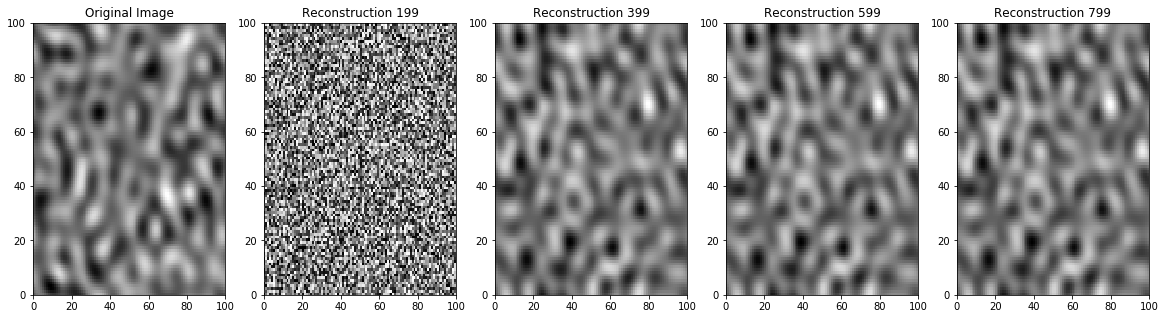

In [166]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
ax[0].pcolor(image, cmap='gray_r')
ax[0].set_title("Original Image")
for i in range(4):
    ax[i+1].pcolor(rstrack[i*200], cmap='gray_r')
    ax[i+1].set_title("Reconstruction %d" %(199+i*200))

In [56]:
from skimage.measure import compare_ssim as ssim


In [57]:
ssim(image,rstrack[-1])

0.95057283332043996

# Ok so I sorta removed the atomicity requirements , so that didn't wokr v well. WIll try now with more complex atom circle based structures

In [62]:
uc_size = 100
th = np.linspace(0,2*np.pi,11)
circ_mu = np.array([[50+20*np.cos(t),50+20*np.sin(t)] for t in th[:-1]])
uc = np.zeros((uc_size,uc_size))
X,Y = np.meshgrid(np.arange(uc_size),np.arange(uc_size))
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
for i in range(circ_mu.shape[0]):
    mvn = multivariate_normal(mean=circ_mu[i],cov = uc_size/10.)
    uc = uc + mvn.pdf(pos)

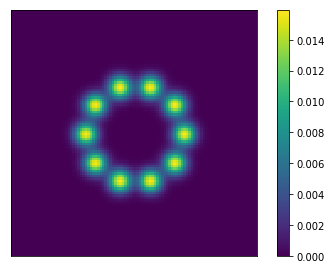

In [219]:
plt.figure()
plt.imshow(uc)
plt.tight_layout()
frame1=plt.gca()
frame1.get_xaxis().set_visible(False)
frame1.get_yaxis().set_visible(False)
plt.colorbar()
plt.savefig(_SAVEDIR_+"gaussian_ring.png")
plt.show()

In [70]:
N_samp = 10
final_images = np.zeros([N_samp, uc_size,uc_size])
mags = np.abs(np.fft.fft2(uc))
for i in range(N_samp):
    print(i)
    rstrack, err_track = pr.inputoutput(mags)
    final_images[i] = rstrack[-1]


0
1
2
3
4
5
6
7
8
9


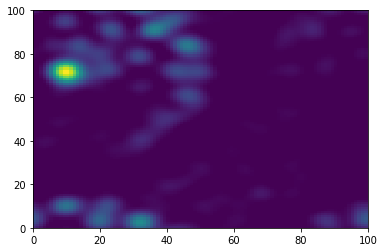

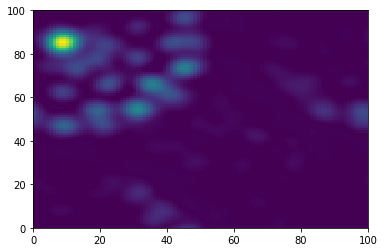

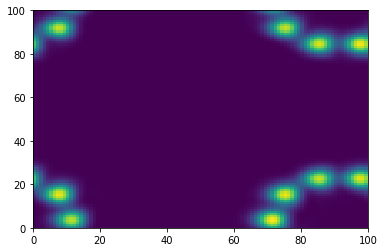

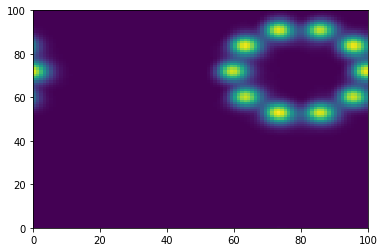

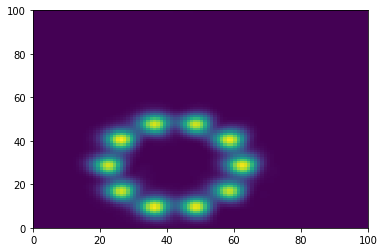

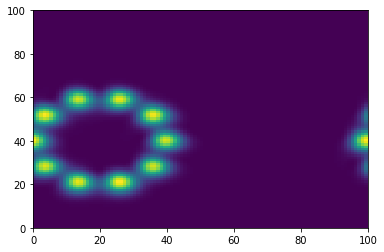

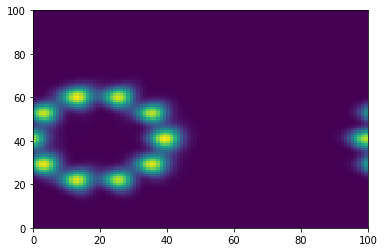

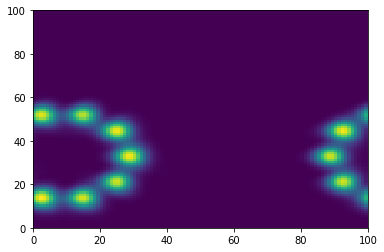

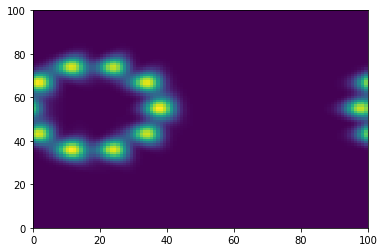

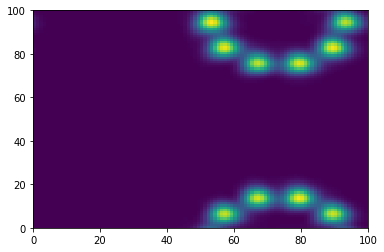

In [71]:
for i in range(N_samp):
    plt.pcolor(final_images[i])
    plt.show()

(10, 100, 100)


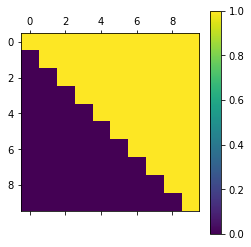

In [85]:
# now compare fourier magnitudes
guess_mags = np.zeros_like(final_images)
print(guess_mags.shape)
for i in range(N_samp):
    x = np.abs(np.fft.fftshift(np.fft.fft2(final_images[i])))
    guess_mags[i] += x

sim_matrix = np.zeros([N_samp,N_samp])
for i in range(N_samp):
    for j in range(i,N_samp):
        sim_matrix[i,j] = ssim(guess_mag[i],guess_mag[j])

# for i in range(N_samp):
#     for j in range(N_samp):
#         sim_matrix[i,j] = ssim(guess_mag[i],guess_mag[j])

#         plt.imshow(guess_mag)
#         plt.show()
plt.matshow(sim_matrix)
plt.colorbar()
plt.show()

(10, 100, 100)


/home/ianhi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


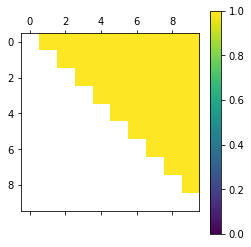

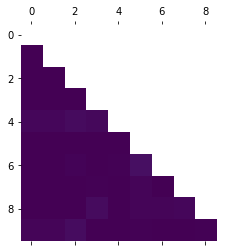

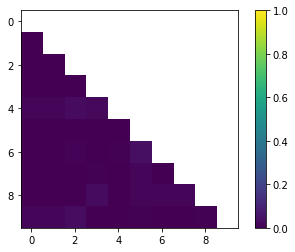

In [116]:
# now compare fourier phases
guess_mags = np.zeros_like(final_images)
guess_FTs = np.zeros_like(final_images)
print(guess_mags.shape)
for i in range(N_samp):
    guess_FTs[i] = np.fft.fftshift(np.fft.fft2(final_images[i]))
    guess_mags[i] += np.abs(guess_FTs[i])

mag_sim_matrix = np.zeros([N_samp,N_samp])
phase_sim_matrix = np.zeros([N_samp,N_samp])
for i in range(N_samp):
    for j in range(i,N_samp):
        mag_sim_matrix[i,j] = ssim(guess_mag[i],guess_mag[j])
        phase_sim_matrix[i,j] = ssim(get_phase(guess_FTs[i]),get_phase(guess_FTs[j]))

mask =  np.tri(mag_sim_matrix.shape[0], k=0)
mag_sim_matrix = np.ma.array(mag_sim_matrix, mask=mask) # mask out the lower triangle
cmap = cm.get_cmap('viridis', 120) # jet doesn't have white color
cmap.set_bad('w') # default value is 'k'

plt.matshow(mag_sim_matrix,cmap = cmap,vmin = 0,vmax= 1)

plt.colorbar()
plt.show()

phase_sim_matrix = np.ma.array(phase_sim_matrix, mask=mask) # mask out the lower triangle
ax1 = plt.axes(frameon=False)
ax1.matshow(phase_sim_matrix.T,vmin=0,vmax=1)
# ax1.colorbar()
plt.show()
fig = plt.figure(frameon=False)
plt.imshow(phase_sim_matrix.T,vmin = 0,vmax= 1)
# plt.frame('off')
plt.colorbar()
plt.show()

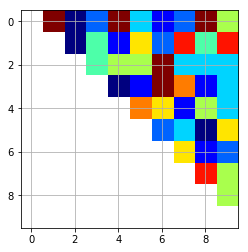

In [91]:


A = np.random.randint(10, 100, 100).reshape(10, 10)
mask =  np.tri(A.shape[0], k=0)
A = np.ma.array(A, mask=mask) # mask out the lower triangle
fig = plt.figure()
ax1 = fig.add_subplot(111)
cmap = cm.get_cmap('jet', 10) # jet doesn't have white color
cmap.set_bad('w') # default value is 'k'
ax1.imshow(A, interpolation="nearest", cmap=cmap)
ax1.grid(True)
plt.show()

In [92]:
A

masked_array(data =
 [[-- 98 12 31 96 43 21 34 98 59]
 [-- -- 13 52 24 63 34 89 50 85]
 [-- -- -- 49 59 57 92 42 41 45]
 [-- -- -- -- 13 24 98 75 20 42]
 [-- -- -- -- -- 77 67 21 61 40]
 [-- -- -- -- -- -- 32 44 10 63]
 [-- -- -- -- -- -- -- 71 20 34]
 [-- -- -- -- -- -- -- -- 81 56]
 [-- -- -- -- -- -- -- -- -- 61]
 [-- -- -- -- -- -- -- -- -- --]],
             mask =
 [[ True False False False False False False False False False]
 [ True  True False False False False False False False False]
 [ True  True  True False False False False False False False]
 [ True  True  True  True False False False False False False]
 [ True  True  True  True  True False False False False False]
 [ True  True  True  True  True  True False False False False]
 [ True  True  True  True  True  True  True False False False]
 [ True  True  True  True  True  True  True  True False False]
 [ True  True  True  True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True  True  True  Tr

In [117]:
N_samp = 10
final_images_noise = np.zeros([N_samp, uc_size,uc_size])
mags_noise = np.abs(np.fft.fft2(image))
for i in range(N_samp):
    print(i)
    rstrack, err_track = pr.inputoutput(mags_noise)
    final_images_noise[i] = rstrack[-1]


0
1
2
3
4
5
6
7
8
9


(10, 100, 100)


/home/ianhi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
/home/ianhi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


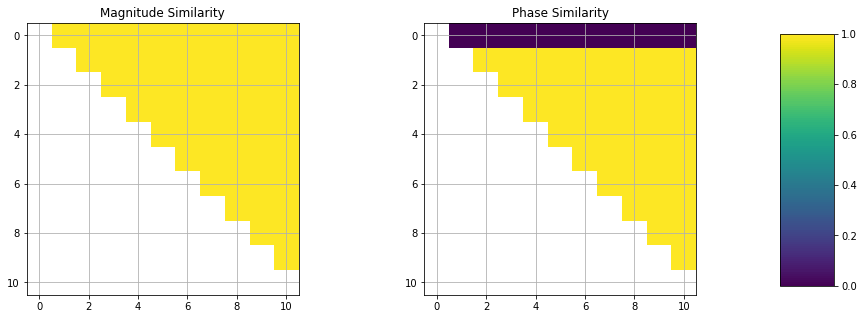

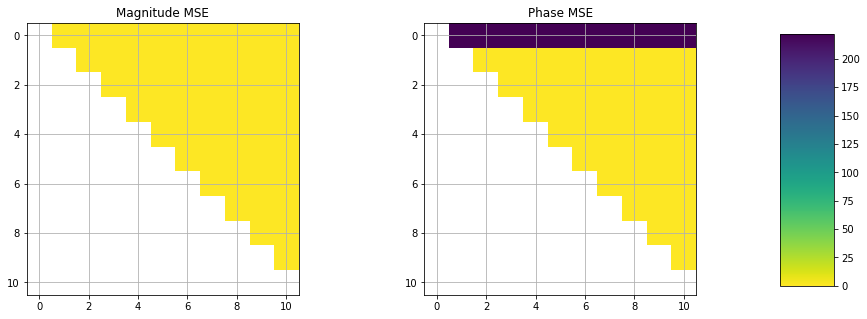

In [236]:
def mse(x, y):
    return np.linalg.norm(x - y)
def sim_matrices(final_images, original_image,_SAVEDIR_ = _SAVEDIR_, savename=None):
    final_images_tmp = np.copy(final_images)
    final_images = np.zeros([final_images.shape[0]+1,final_images.shape[1],final_images.shape[2]])
    print(final_images_tmp.shape)
    guess_mags = np.zeros_like(final_images)
    guess_FTs = np.zeros_like(final_images)
    
    final_images[0] = np.fft.fftshift(np.fft.fft2(image))
    final_images[1:] = final_images_tmp
    for i in range(0,N_samp+1):
        guess_FTs[i] = np.fft.fftshift(np.fft.fft2(final_images[i]))
        guess_mags[i] += np.abs(guess_FTs[i])

    mag_sim_matrix = np.zeros([N_samp+1,N_samp+1])
    mag_mse_matrix = np.zeros([N_samp+1,N_samp+1])
    phase_sim_matrix = np.zeros([N_samp+1,N_samp+1])
    phase_mse_matrix = np.zeros([N_samp+1,N_samp+1])
    for i in range(N_samp+1):
        for j in range(i,N_samp+1):
            mag_sim_matrix[i,j] = ssim(guess_mag[i],guess_mag[j])
            phase_sim_matrix[i,j] = ssim(get_phase(guess_FTs[i]),get_phase(guess_FTs[j]))
            phase_mse_matrix[i,j] = mse(get_phase(guess_FTs[i]),get_phase(guess_FTs[j]))
            mag_mse_matrix[i,j] = mse(guess_mag[i],guess_mag[j])
    mask =  np.tri(mag_sim_matrix.shape[0], k=0)
    cmap = cm.get_cmap('viridis', 120) # jet doesn't have white color
    cmap.set_bad('w') # default value is 'k'
    
    cmap_r = cm.get_cmap('viridis_r', 120) # jet doesn't have white color
    cmap_r.set_bad('w') # default value is 'k'

    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
    axes = list(axes.flat)
    mag_sim_matrix = np.ma.array(mag_sim_matrix, mask=mask) # mask out the lower triangle
    axes[0].imshow(mag_sim_matrix,cmap = cmap,vmin = 0,vmax= 1)
    axes[0].set_title('Magnitude Similarity')
    axes[0].grid(which='major')
    
    
    phase_sim_matrix = np.ma.array(phase_sim_matrix, mask=mask) # mask out the lower triangle
    im = axes[1].imshow(phase_sim_matrix,cmap= cmap,vmin = 0,vmax= 1,)
    axes[1].grid()
    axes[1].set_title('Phase Similarity')
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    if savename is not None:
        plt.savefig(_SAVEDIR_+'sim_'+savename,transparent=True)
    plt.show()
    
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
    max_mse = np.max((np.max(mag_mse_matrix),np.max(phase_mse_matrix)))

    mag_mse_matrix = np.ma.array(mag_mse_matrix, mask=mask) # mask out the lower triangle
    phase_mse_matrix = np.ma.array(phase_mse_matrix, mask=mask) # mask out the lower triangle

#     max_mse = np.max(np.max(mag_mse_matrix),np.max(phase_mse_matrix))
    axes[0].imshow(mag_mse_matrix,cmap = 'viridis_r', vmin = 0,vmax= max_mse)
    axes[0].set_title('Magnitude MSE')
    axes[0].grid(which='major')
#     labels = []
#     for i in np.arange(10):
#         labels.append(i)
#     labels[0]='Truth'
#     print(labels)
#     axes[0].set_xticks(np.arange(10), labels)
#     axes[0].set_xticklabels(locs= np.arange, labels = labels)



    im = axes[1].imshow(phase_mse_matrix,cmap= 'viridis_r',vmin = 0,vmax= max_mse)
    axes[1].set_title('Phase MSE')
    axes[1].grid()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    if savename is not None:
        plt.savefig(_SAVEDIR_+'mse_'+savename,transparent=True)

    plt.show()
sim_matrices(final_images_noise,image,savename='noise.png')

(10, 100, 100)


/home/ianhi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
/home/ianhi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


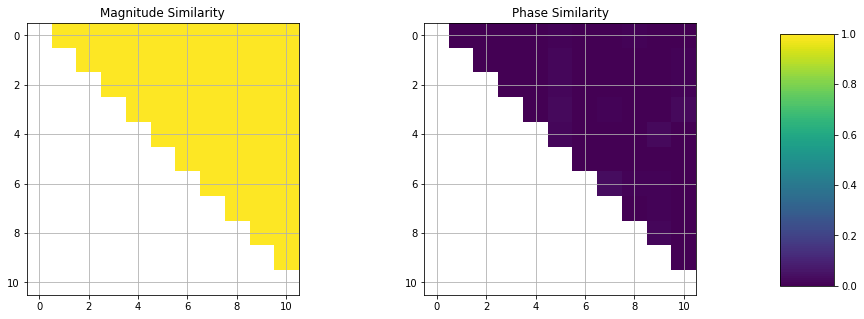

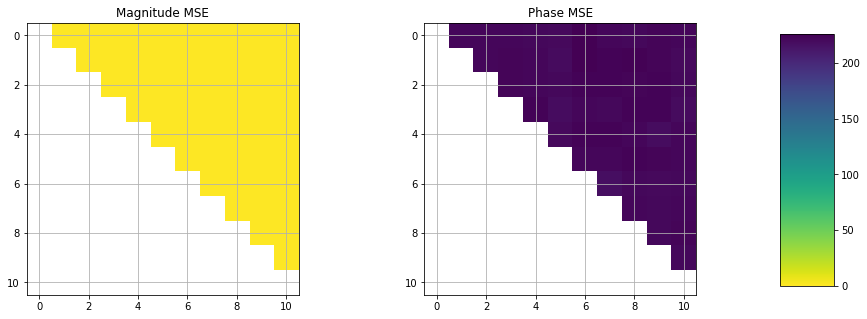

In [237]:
sim_matrices(final_images,uc,savename='gaussian_ring.png')